Import libraries

In [381]:
import pandas as pd
import numpy as np
import requests
import json
import os
import geopandas as gpd
import copy as cp

In [2]:
# create 'data/' folder 
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder('./data/')

In [4]:
# get data and write to files

ic_url = 'http://opendatacommunities.org/downloads/cube-table?uri=http%3A%2F%2Fopendatacommunities.org%2Fdata%2Fsocietal-wellbeing%2Fdeprivation%2Fimd-income-score-2010'

r = requests.get(ic_url)
name = ic_url.split('%2F')[-2] + '_' + ic_url.split('%2F')[-1]
fo = open('data/' + name + '.csv', 'wb')
fo.write(r.content)
fo.close()

In [42]:
# load files (those that were just downloaded, plus the census one)

imd_income = pd.read_csv('data/deprivation_imd-income-score-2010.csv')
cen_nssec = pd.read_csv('Data_Health_Job.csv')
cen_health = pd.read_csv('Data_Disability.csv')
cen_depr = pd.read_csv('Data_Deprivation.csv')
cen_socec = pd.read_csv('Data_SocEc.csv')

In [372]:
# make functions to organise data

def get_meta_data(data):
    # remove unwanted columns
    meta_data = (data.drop(['CDU_ID', 'GEO_CODE', 'GEO_LABEL', 'GEO_TYPE', 'GEO_TYP2'], axis = 1)\
                .iloc[:1]\
                .T
                )
    
    # separate into various columns
    for i in range(meta_data.iloc[0][0].count(' - ')):
        name = str(meta_data.iloc[0][0].split(' - ')[i].split(' : ')[0])
        
        # extract individual strings
        temp_list = []
        for j in range(len(meta_data)):
            var_string = str(meta_data.iloc[j][0].split(' - ')[i].split(' : ')[1])
            temp_list.append(var_string)
            #print(temp_list)

        # make columns
        meta_data[name] = temp_list
        #print(temp_list)
        
    # remove unwanted column
    meta_data = meta_data.drop([0], axis = 1)
    
    # clean headers
    meta_data.columns = meta_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(')', '').str.replace('(', '').str.replace(';', '')
        
    return(meta_data)


def clean_census_data(data):
    # remove unwanted columns
    clean_data = (data.drop(['CDU_ID', 'GEO_LABEL', 'GEO_TYPE', 'GEO_TYP2'], axis =1)\
                  .drop([0], axis = 0)\
                  .set_index('GEO_CODE')\
                  .T)
    
    # merge with census data
    #meta_data = get_meta_data(data)
    #clean_data = meta_data.join(clean_data)
    
    return(clean_data)

def filter_totals(cen_data):
    
    meta_data = get_meta_data(cen_data)

    for i in range(len(meta_data)):
        for j in range(len(meta_data.columns)):
            if 'Total\ ' in meta_data.iloc[i][j]: #dat.iloc[1][3] # [row] [column]
                meta_data.iloc[i][j] = np.nan
            
    meta_data = meta_data.dropna(axis = 0)
    
    # get column names for filtering
    cl_cen_dat = clean_census_data(cen_data)
    col_list = []
    for i in range(len(cl_cen_dat.columns)):
        if 'E01' in cl_cen_dat.columns[i]:
            col_list.append(cl_cen_dat.columns[i])
    
    # merge with census data
    data = meta_data.join(cl_cen_dat)
    data = data[col_list]
    
    return(data.T)

In [363]:
def pnt_of_tot(old_data):
    
    data = old_data.T.astype(int)
    data['sum'] = data.sum(axis = 1, skipna = all)
    
    new_df = pd.DataFrame(index = data.index, columns = data.columns)
    for i in range(len(data)):
        for j in range(int(len(data.columns) - 1)):
            new_df.iloc[i][j] = (data.iloc[i][j] / data.iloc[i][int(len(data.columns) - 1)] * 100)
    
    new_df = new_df.dropna(axis = 1)

    return(new_df)

In [379]:
# clean dataframes

dat_nssec = pnt_of_tot(filter_totals(cen_nssec))
dat_health = pnt_of_tot(filter_totals(cen_health))
dat_depr = pnt_of_tot(filter_totals(cen_depr))
dat_socec = pnt_of_tot(filter_totals(cen_socec))
dat_heat = pnt_of_tot(clean_census_data(cen_heat).T) # have to use clean_census_data() here becasue I only downloaded totals

In [382]:
neis = gpd.read_file('shapefiles/Unit2_exercise1Data/with_OA.shp')

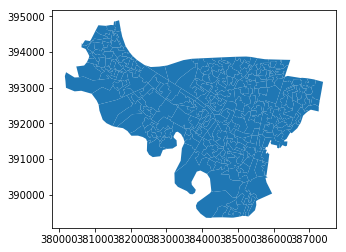

In [385]:
neis.plot()

In [389]:
neis = gpd.read_file('lsoas/Lower_Layer_Super_Output_Areas_December_2001_Generalised_Clipped_Boundaries_in_England_and_Wales.shp')

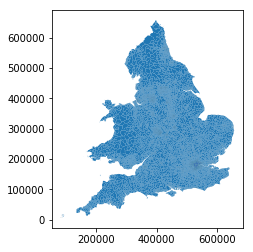

In [390]:
neis.plot()